In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastai.basics import set_seed
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

import torch.nn.functional as F

plt.style.use('seaborn-colorblind')

#import glob

In [34]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        with torch.no_grad():
            z = self.gan.noise(x_cont)
            fake_samples = self.gan.generator(x_cat, z)
        return fake_samples
    
    def fit(self, dl, epochs=10, lr=1e-3, plot_epochs=10, save_model=False, figsize=(16, 9)):
        
        self.gan.to_device(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self.gan.gen_optim.param_groups[0]['lr'] = lr
        self.gan.dis_optim.param_groups[0]['lr'] = lr
        
        self.gan.train()
        
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                #x_cat[:] = 0
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                #plt.figure(figsize=figsize)
                #plt.plot(self.gan.real_loss, label='Real Loss')
                #plt.plot(self.gan.fake_loss, label='Fake Loss')
                #if len(self.gan.aux_loss) > 0:
                #    plt.plot(self.gan.aux_loss, label='Aux Loss')
                #plt.legend()
                #plt.show()
                
                fig, ax1 = plt.subplots(figsize=figsize)

                ax1.set_xlabel('iterations')
                ax1.set_ylabel('bce loss')
                ax1.plot(self.gan.real_loss, label='real')
                ax1.plot(self.gan.fake_loss, label='fake') 
                ax1.tick_params(axis='y')
                ax1.legend(loc='upper right')
                ax2 = ax1.twinx()

                ax2.set_ylabel('aux loss')
                ax2.plot(self.gan.aux_loss, label='aux')
                ax2.tick_params(axis='y')
                ax2.legend(loc='lower right')
                
                fig.tight_layout()
                plt.show()
        
        self.gan.eval()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

 90%|█████████ | 9/10 [00:11<00:01,  1.32s/it]

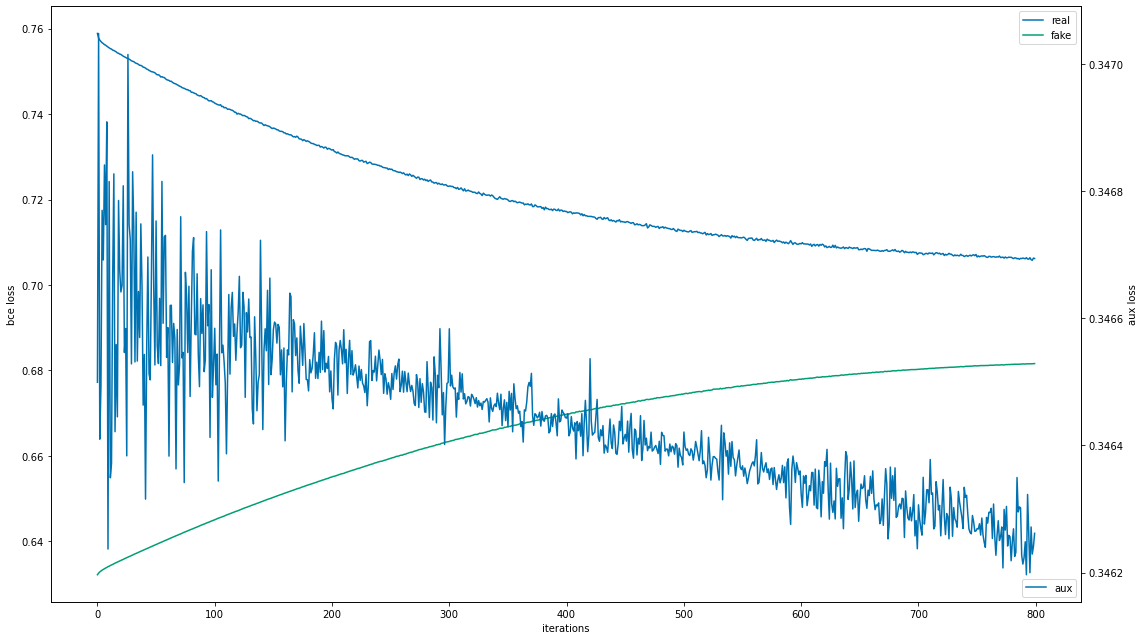

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


In [36]:
set_seed(1337)

n_samples = 1024*10
n_classes = 4
n_features = 1
batch_size = 512
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 10
lr = 1e-5
n_gen = 1
n_dis = 1
gan_type = 'aux'
aux_factor = 1/4

data = GaussianDataset(n_samples, n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

emb = EmbeddingModule(categorical_dimensions=[n_classes+1])
model = get_gan_model(gan_type=gan_type, structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb, bn=True, aux_factor=aux_factor)

learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

distribution of real data:


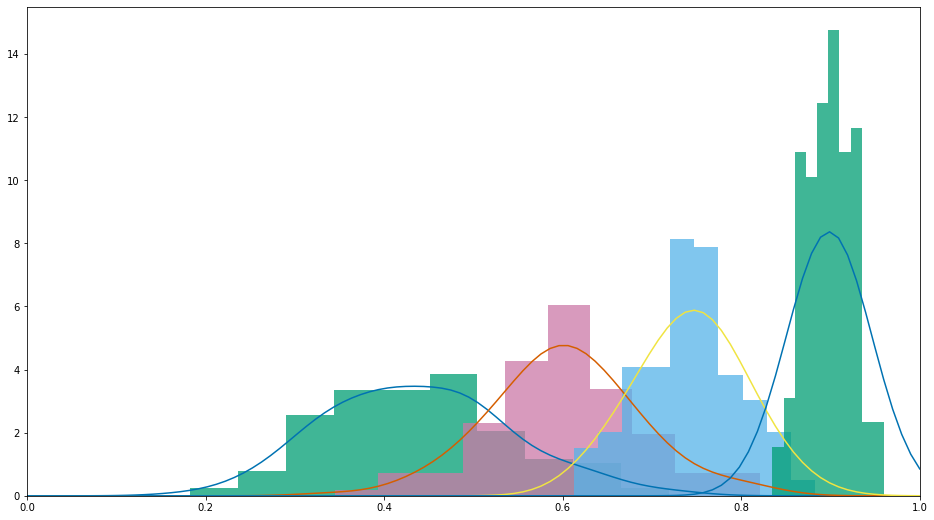

distribution of generated data:


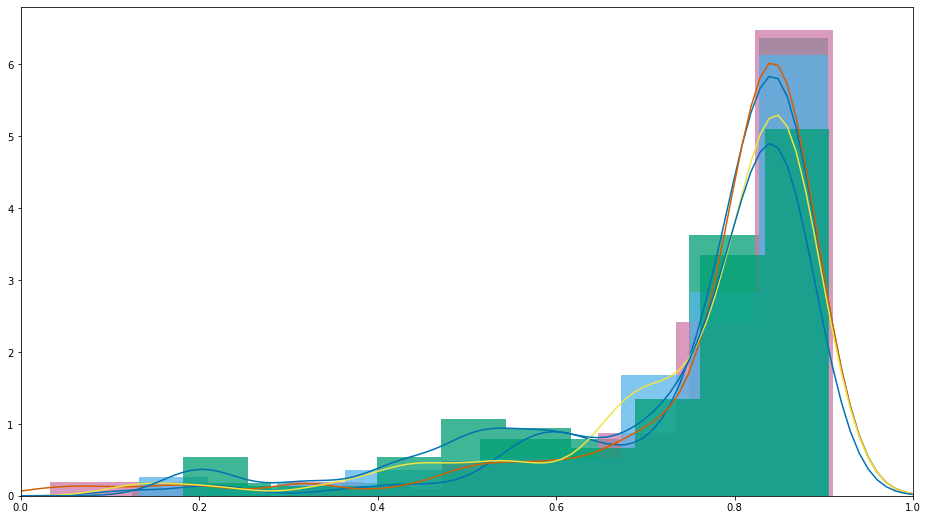

distribution of generated data:


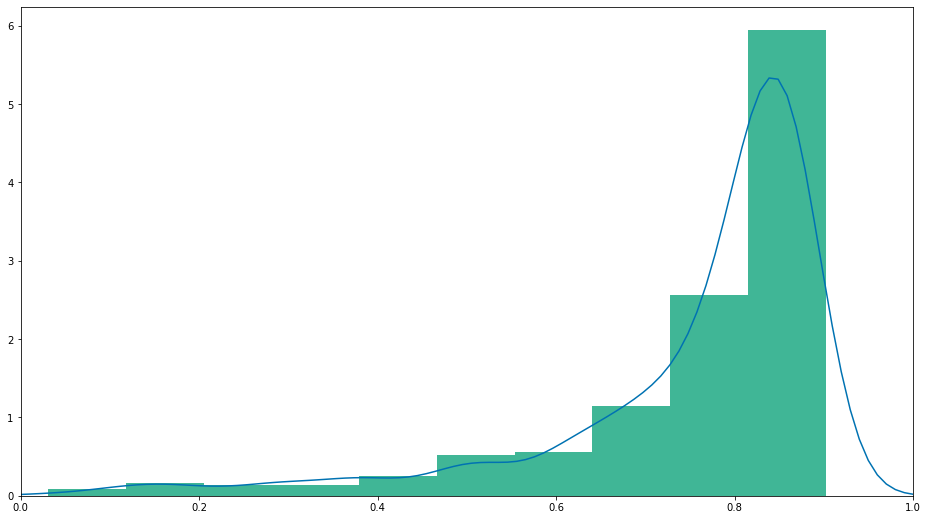

distribution of generated data:


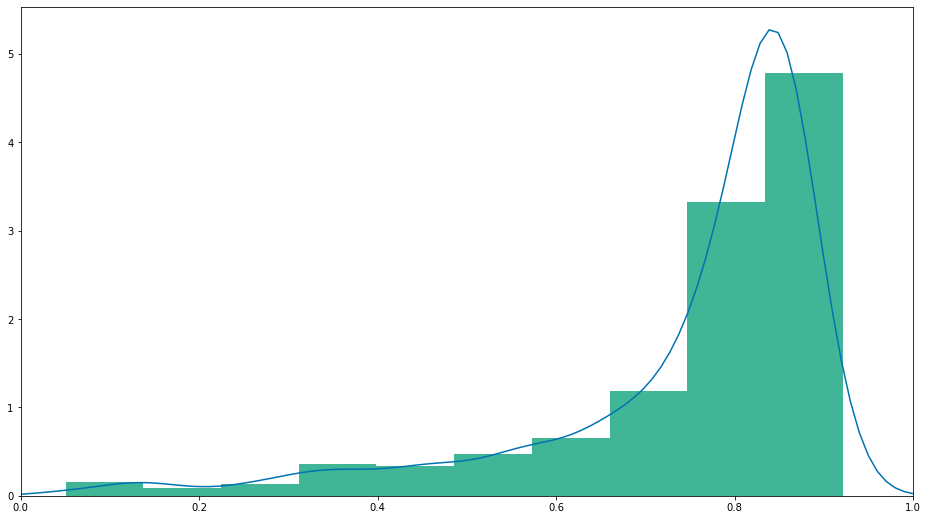

distribution of generated data:


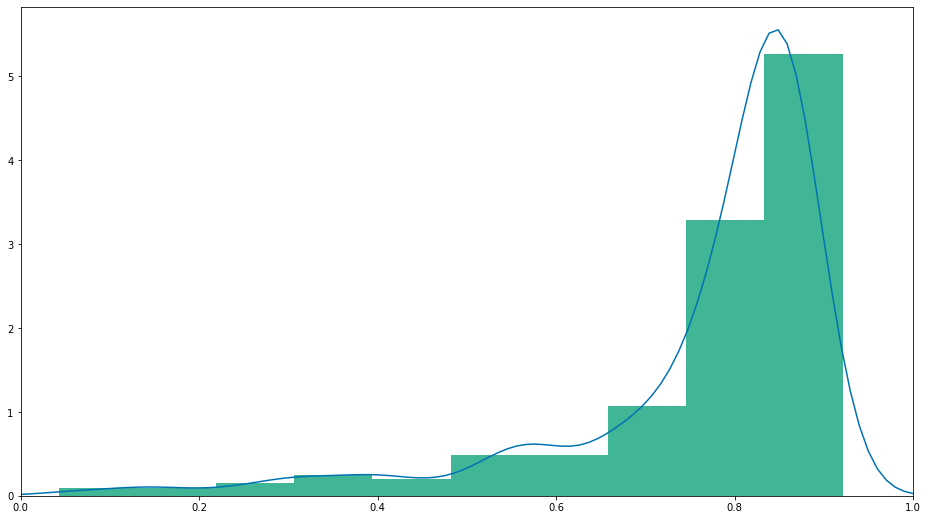

distribution of generated data:


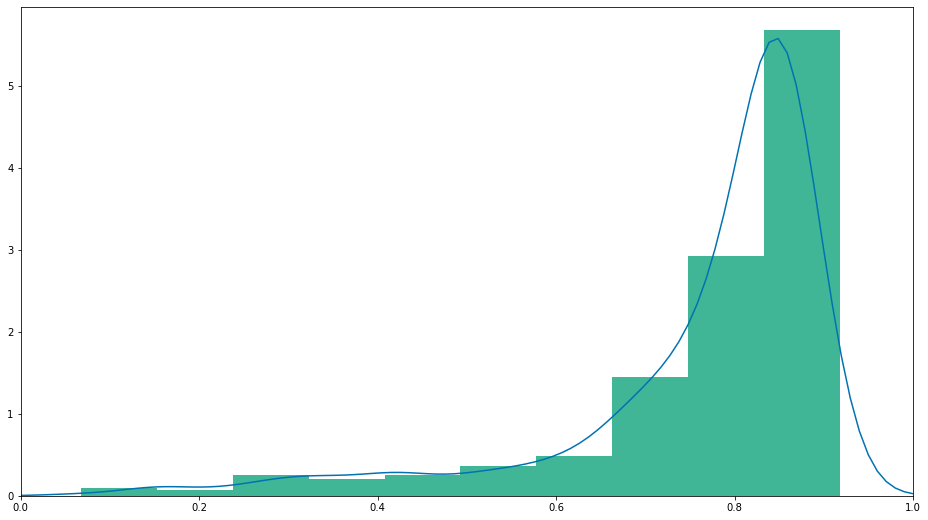

In [5]:
set_seed(1337)

for x_cat, x_cont, y in dl:
    x_cat = x_cat.long()
    print('distribution of real data:')
    plot_class_hists(x_cat, x_cont, bandwidth=1/25)

    x_fake = learner.generate_samples(x_cat, x_cont)
    print('distribution of generated data:')
    plot_class_hists(x_cat, x_fake, bandwidth=1/25)

    for t_id in range(1, n_classes+1):
        x_cat[:] = t_id
        x_fake = learner.generate_samples(x_cat, x_cont)
        print('distribution of generated data:')
        plot_class_hists(x_cat, x_fake, bandwidth=1/25)
    break

In [37]:
def evaluate_gan(gan_type, aux_factor, epochs=10):
    
    set_seed(1337)
    model = get_gan_model(gan_type=gan_type, structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb, bn=True, aux_factor=aux_factor)
    learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
    learner.fit(dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.long()
        print('distribution of real data:')
        d_real = fit_kde(x_cont, bandwidth=1/25)
        x_fake = learner.generate_samples(x_cat, x_cont)
        print('distribution of generated data:')
        d_fake = fit_kde(x_fake, bandwidth=1/25)
        break
    kld = calculate_kld(d_real, d_fake)
        
    return kld

 90%|█████████ | 9/10 [00:10<00:01,  1.22s/it]

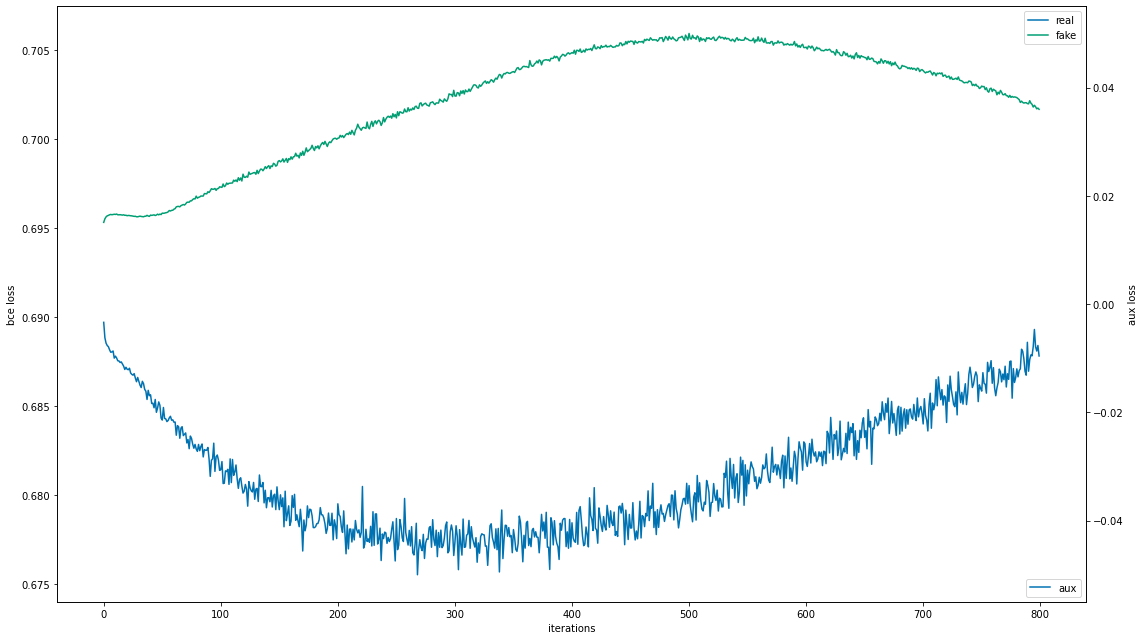

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


distribution of real data:


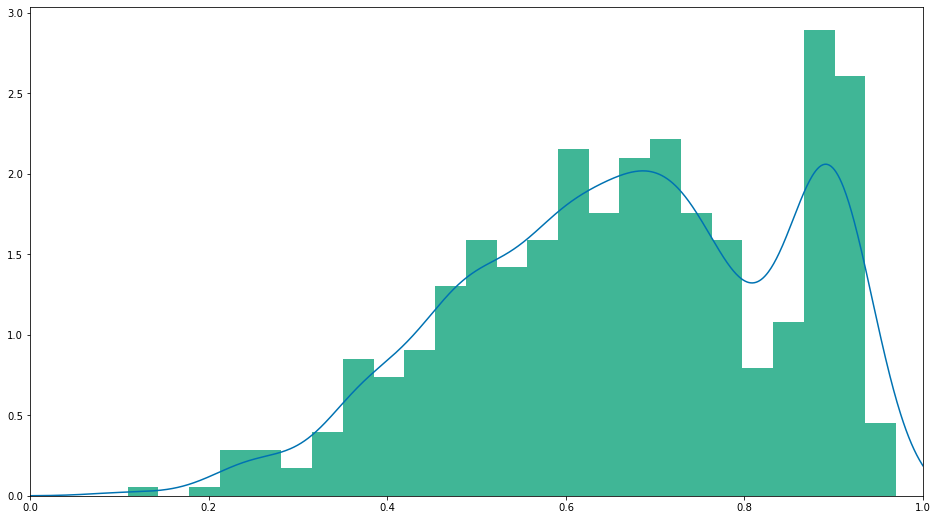

distribution of generated data:


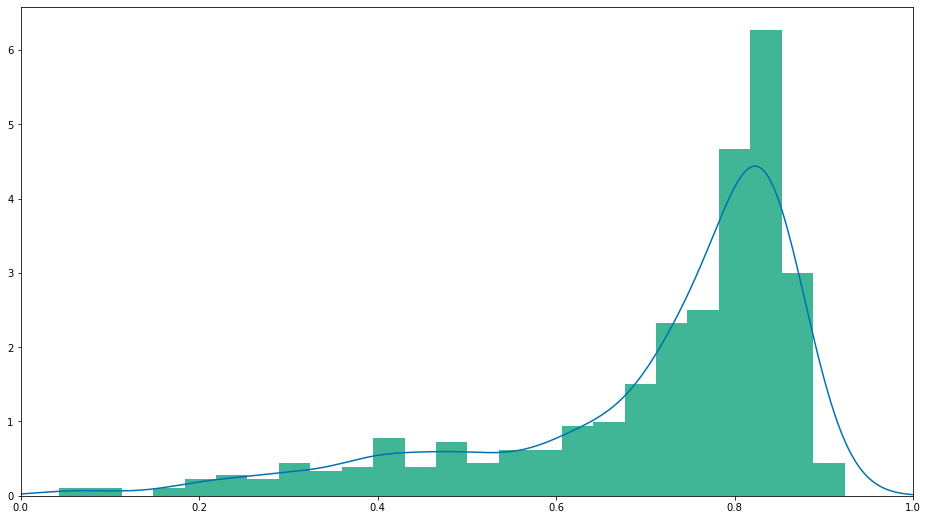

 90%|█████████ | 9/10 [00:12<00:01,  1.34s/it]

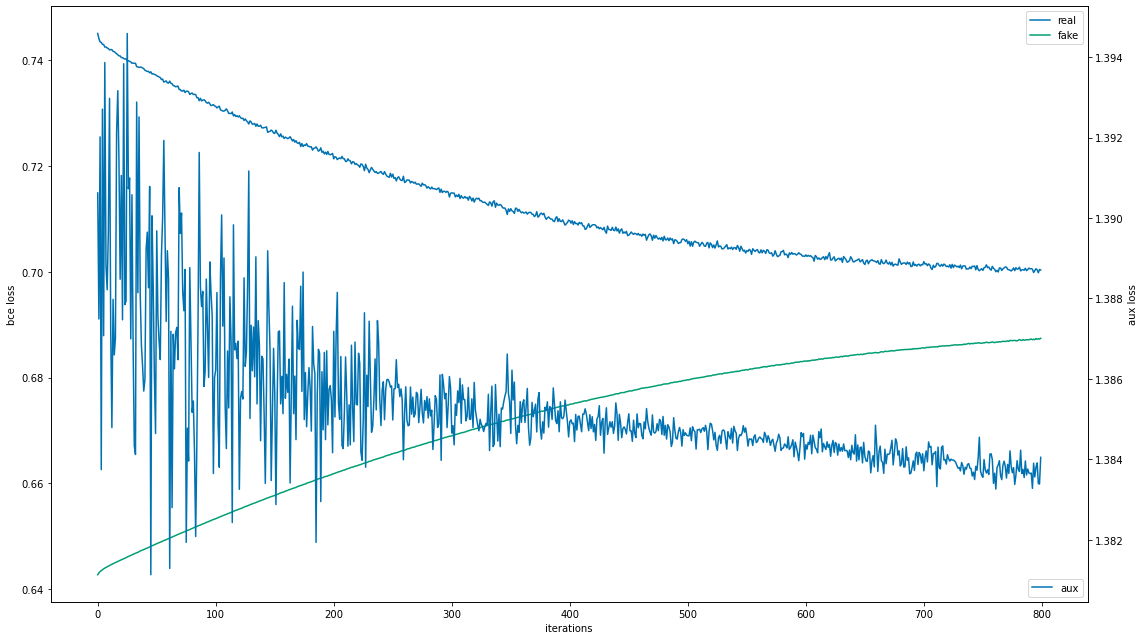

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


distribution of real data:


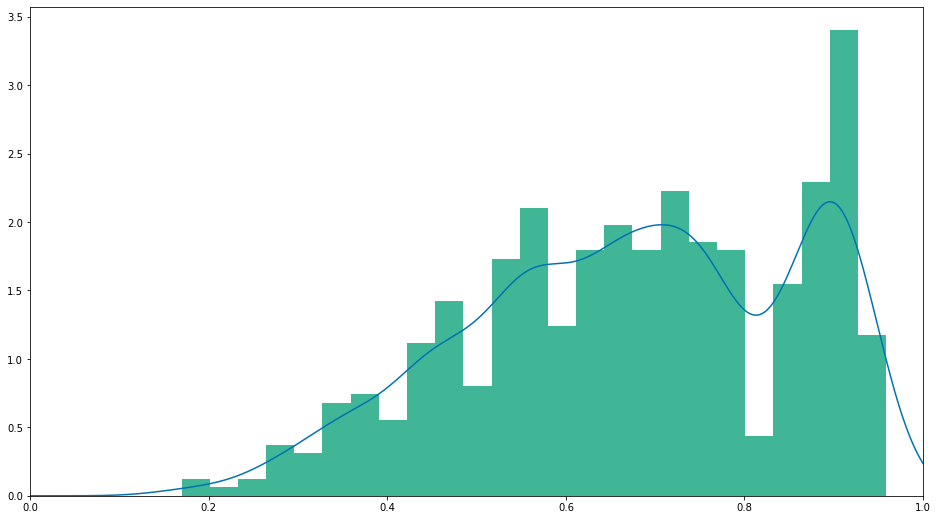

distribution of generated data:


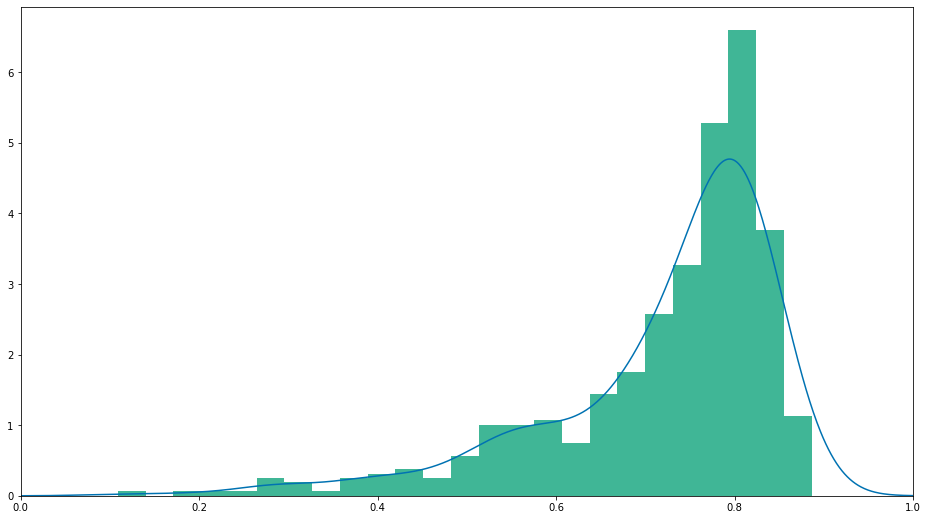

 90%|█████████ | 9/10 [00:12<00:01,  1.34s/it]

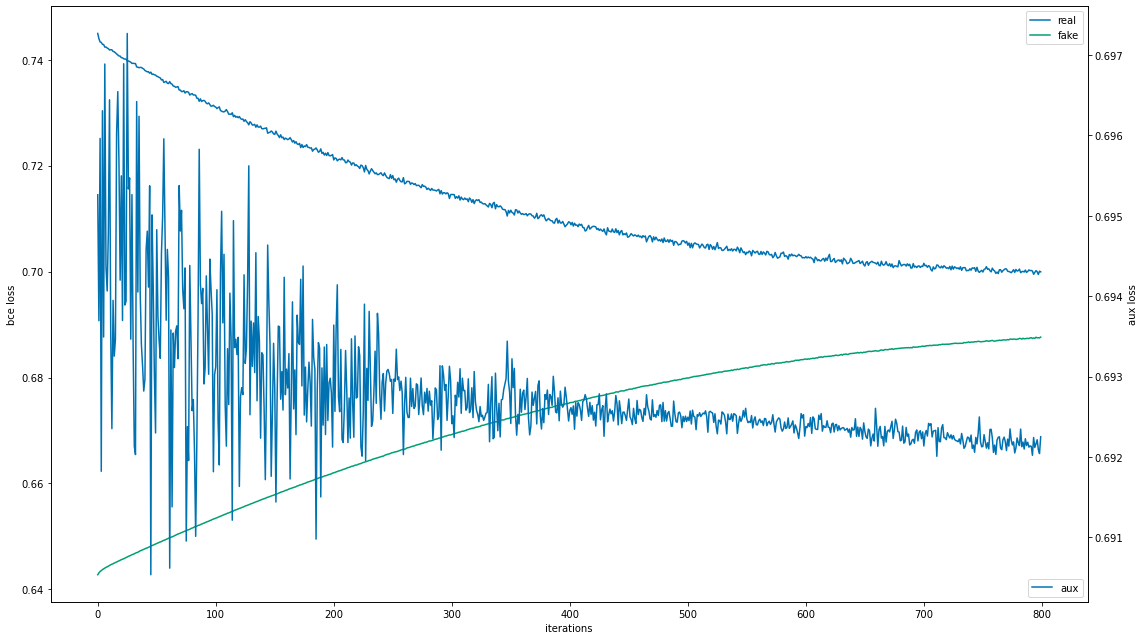

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


distribution of real data:


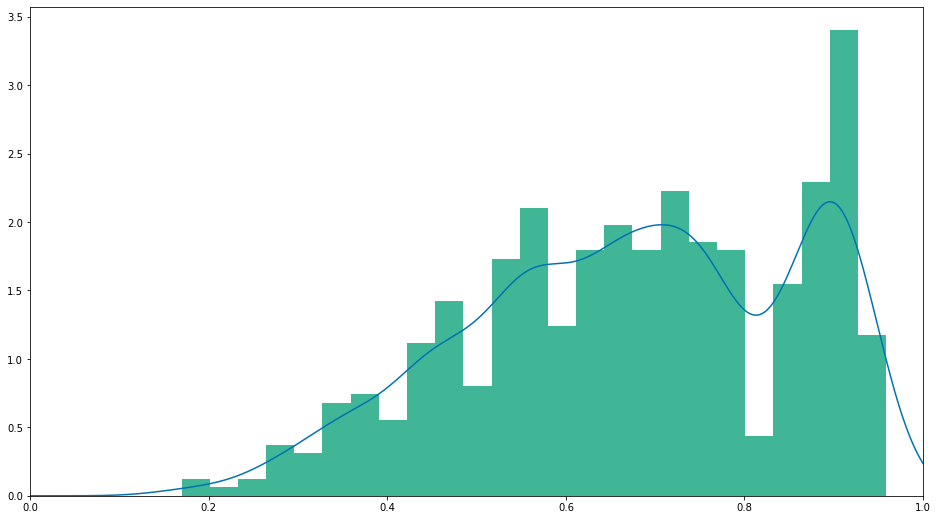

distribution of generated data:


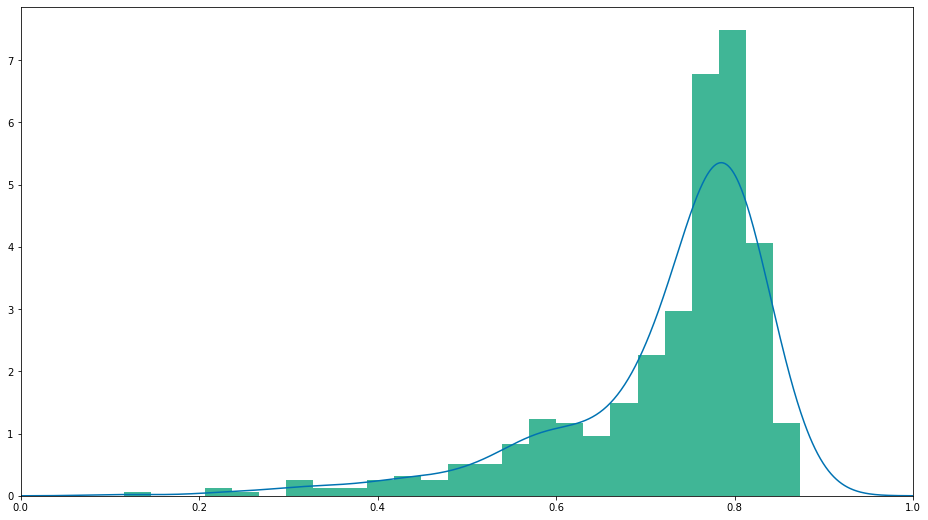

 90%|█████████ | 9/10 [00:12<00:01,  1.35s/it]

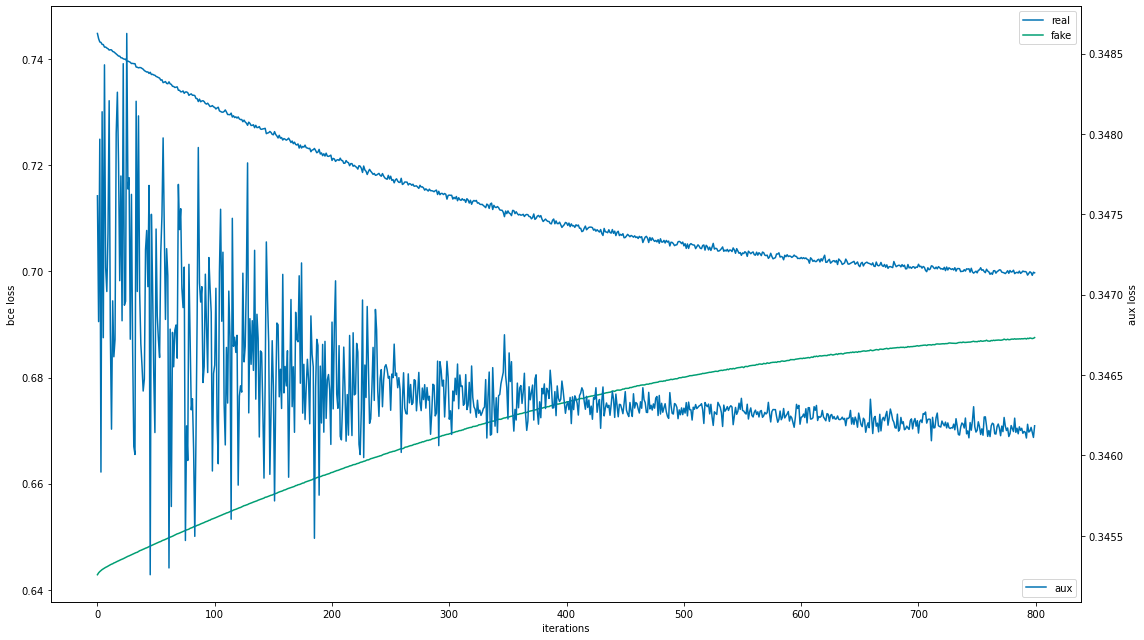

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


distribution of real data:


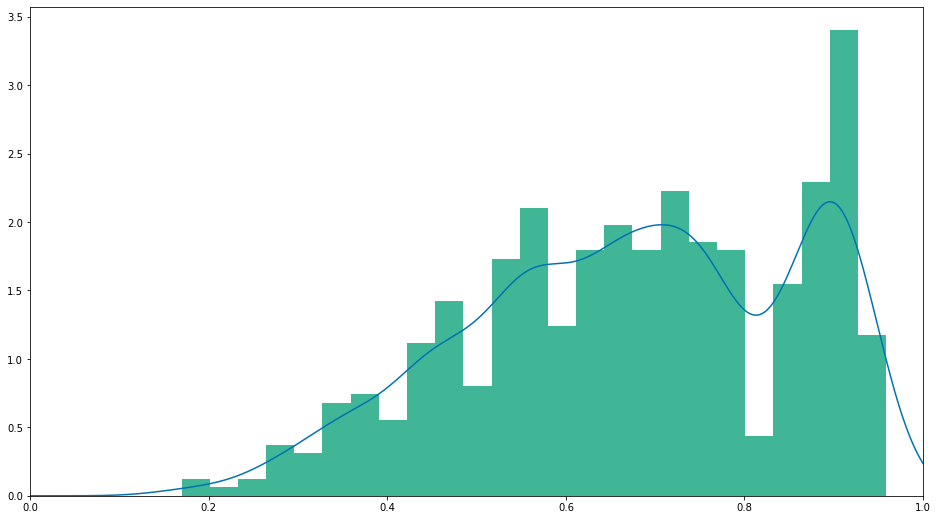

distribution of generated data:


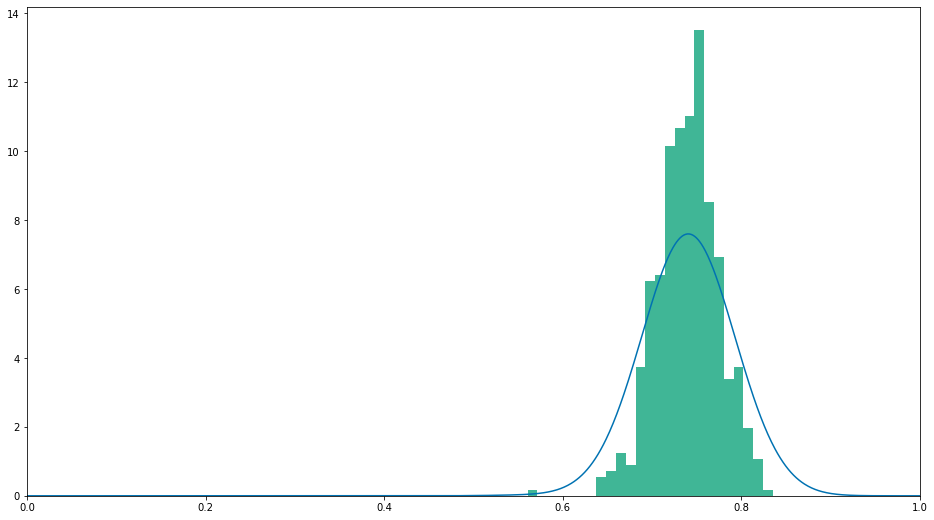

In [38]:
emb = EmbeddingModule(categorical_dimensions=[n_classes+1])

klds = []
klds.append(evaluate_gan('bce', 1))
klds.append(evaluate_gan('aux', 1))
klds.append(evaluate_gan('aux', 1/2))
klds.append(evaluate_gan('aux', 1/4))
klds.append(evaluate_gan('aux', 1/8))
klds.append(evaluate_gan('aux', 1/16))